In [1]:
import pandas as pd
import psycopg2 

In [2]:
conn = psycopg2.connect(
    database="nba", 
    user="chenjie")

In [3]:
df_test = pd.read_sql('select * from player_game_scoring', conn)

/var/folders/sl/1_4_3jg90p50ft92b5k6mgv00000gn/T/ipykernel_1980/1090044701.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_test = pd.read_sql('select * from player_game_scoring', conn)


In [4]:

df_test.shape

(252242, 31)

In [5]:
list(df_test)

['game_date',
 'home_id',
 'minutes',
 'offposs',
 'points',
 'fg_two_m',
 'fg_two_a',
 'fg_two_pct',
 'fg_three_m',
 'fg_three_a',
 'fg_three_pct',
 'nonheavefg_three_pct',
 'ftpoints',
 'ptsassisted_two_s',
 'ptsunassisted_two_s',
 'ptsassisted_three_s',
 'ptsunassisted_three_s',
 'assisted_two_spct',
 'nonputbacksassisted_two_spct',
 'assisted_three_spct',
 'fg_three_apct',
 'shotqualityavg',
 'efgpct',
 'tspct',
 'ptsputbacks',
 'fg_two_ablocked',
 'fg_two_apctblocked',
 'fg_three_ablocked',
 'fg_three_apctblocked',
 'usage',
 'player_id']

In [6]:
df_test.head()

,game_date,home_id,minutes,offposs,points,fg_two_m,fg_two_a,fg_two_pct,fg_three_m,fg_three_a,...,shotqualityavg,efgpct,tspct,ptsputbacks,fg_two_ablocked,fg_two_apctblocked,fg_three_ablocked,fg_three_apctblocked,usage,player_id
0,2012-11-03,9,46.60,89,9,3,6,0.50,1,4,...,0.59,0.45,0.45,0,1,0.17,0,0.0,12.15,57
1,2012-11-03,9,15.70,29,2,1,5,0.20,0,1,...,0.54,0.17,0.17,0,0,0.00,0,0.0,16.67,61
2,2012-11-03,9,14.93,29,13,2,4,0.50,2,4,...,0.59,0.63,0.59,2,1,0.25,0,0.0,34.29,81
3,2012-11-03,9,20.10,40,2,1,2,0.50,0,5,...,0.53,0.14,0.14,0,0,0.00,0,0.0,14.29,125
4,2012-11-03,9,35.25,68,4,2,7,0.29,0,0,...,0.57,0.29,0.29,2,1,0.14,0,0.0,13.58,133


In [7]:
df_test = df_test.drop(['game_date', 'player_id'], axis=1)

In [8]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

In [9]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

In [10]:
sampled_cols = [ 'minutes', 'points', 'fg_two_pct', 'fg_three_pct', 'ptsassisted_two_s', 'assisted_two_spct', 'shotqualityavg', 'efgpct', 'usage']

In [11]:
data_mpg = df_test[sampled_cols]

In [12]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(data_mpg.columns)]
data = data_mpg.to_numpy()

cg = pc(data)



  0%|          | 0/9 [00:00<?, ?it/s]

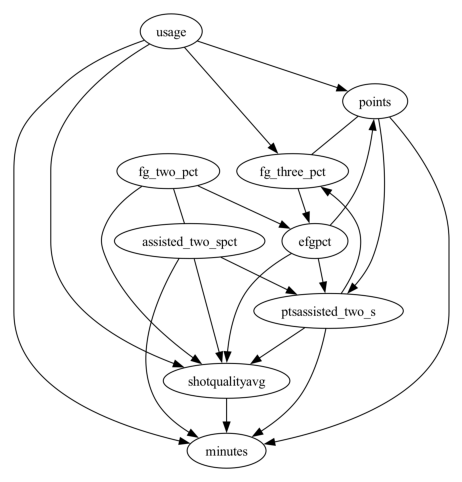

In [13]:
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize=(8, 6))  
plt.axis('off')
plt.imshow(img)
plt.show()

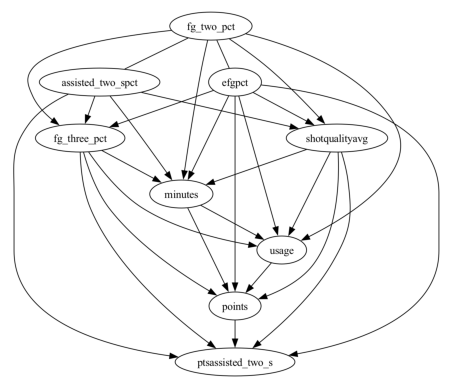

In [14]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

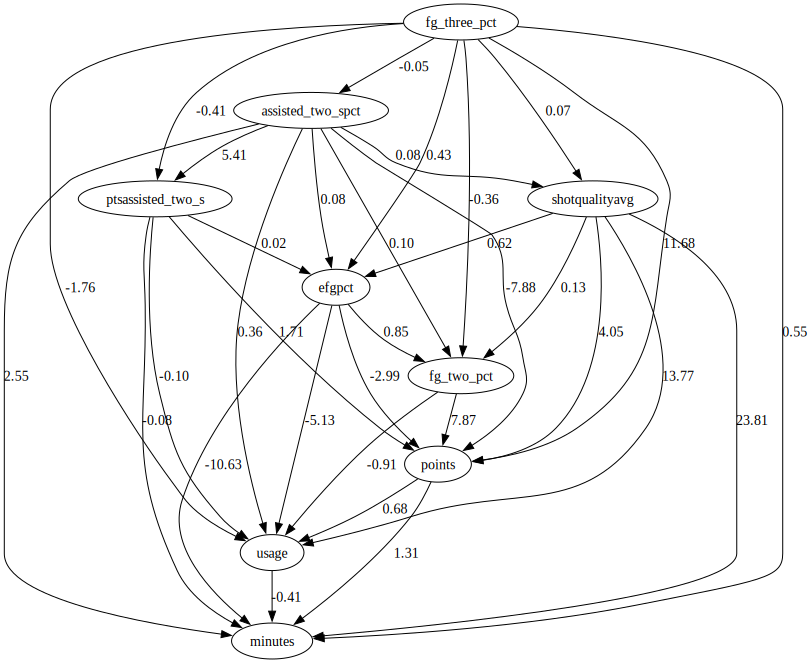

In [15]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

In [16]:
graph_dot = make_graph(model.adjacency_matrix_, labels=labels)

data_df = pd.DataFrame(data=data, columns=labels)

model_est=CausalModel(
        data = data_df,
        treatment='usage',
        outcome='minutes',
        graph=str_to_dot(graph_dot.source))

identified_estimand = model_est.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

estimate = model_est.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)
print("Causal Estimate is " + str(estimate.value))

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                           ↪
────────(E[minutes|fg_three_pct,efgpct,ptsassisted_two_s,points,assisted_two_⟨ ↪
d[usage]                                                                       ↪

↪                    
↪ spct,shotquality⟩])
↪                    
Estimand assumption 1, Unconfoundedness: If U→{usage} and U→minutes then P(minutes|usage,fg_three_pct,efgpct,ptsassisted_two_s,points,assisted_two_spct,shotqualityavg,U) = P(minutes|usage,fg_three_pct,efgpct,ptsassisted_two_s,points,assisted_two_spct,shotqualityavg)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers

/Users/chenjieli/.pyenv/versions/myenv/lib/python3.13/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
